In [2]:
import duckdb
import matplotlib.pyplot as plt
import altair as alt

In [3]:
con = duckdb.connect("benchmark.duckdb", read_only=True)

In [18]:
con.close()

In [4]:
con.execute("SELECT * FROM experiment")
con.fetchall()

[(1674626722156, 'this is a test'),
 (1674627302692, 'this is a test'),
 (1674627750857, 'this is a test'),
 (1674627940130, 'this is a test'),
 (1674628140252, 'this is a test'),
 (1674628200989, 'this is a test'),
 (1674630064396, 'this is a test'),
 (1674630191488, 'this is a test'),
 (1674630856345,
  'looking at queue blocking in a single iteration over a batch'),
 (1674633125818, 'running an iteration without applying the model'),
 (1674633863219,
  'comparing different allocations of videos when running without applying model'),
 (1674684971258,
  'running more fine-grained splits between dali and pytorch, from 30-40, without model'),
 (1674685100592,
  'running with no model and finer-grained splits between pytorch, dali (30-40%)'),
 (1674884244234,
  'running single trial with model to track queue size throughout'),
 (1674884376819, 'just running to get clip counts'),
 (1674885466536, 'testing queue size again; applying model'),
 (1675219643297, 'checking clip counts after adj

In [9]:
con.execute("SELECT * FROM queue_block WHERE eid=1674630856345")
data = con.df()

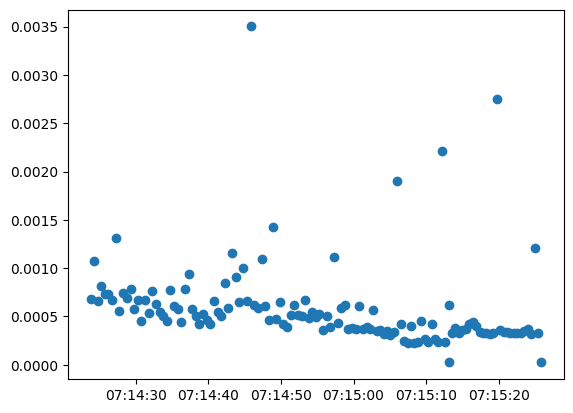

In [17]:
gets = data[data.operation == "get"]
plt.scatter(gets.start_time.iloc[1:], gets.duration.iloc[1:]) # first was major outlier, around 3 seconds

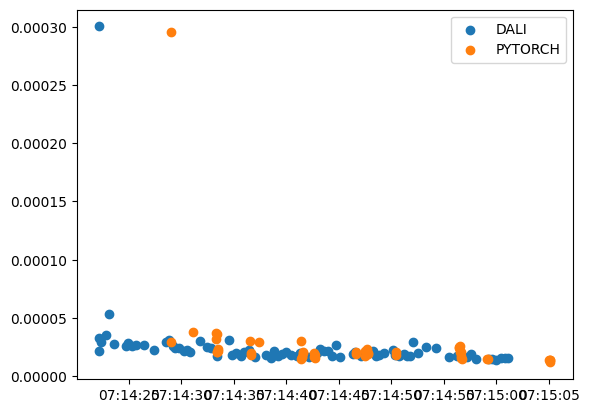

In [21]:
puts = data[data.operation == "put"]
fig, ax = plt.subplots()
ax.scatter(puts[puts.dataloader == "DALI"].start_time, puts[puts.dataloader == "DALI"].duration, label="DALI")
ax.scatter(puts[puts.dataloader == "PYTORCH"].start_time, puts[puts.dataloader == "PYTORCH"].duration, label="PYTORCH")
ax.legend()

In [22]:
con.close()

In [25]:
con.execute("SELECT * FROM queue_block WHERE eid=1674633125818")
modelless_data = con.df()

In [27]:
con.execute("SELECT * FROM combo_full_benchmark WHERE eid=1674633125818")
con.fetchall()

[(1674633125818, 0, 4, 6, 1018, 44.179744720458984)]

In [6]:
con.execute("SELECT * FROM combo_full_benchmark WHERE eid=1674633863219")
data = con.df()
con.close()

In [8]:
grouped_portion = data.groupby("pytorch_portion").agg({"clip_count": "sum", "clock_time": "mean"})

Text(0.5, 0, 'portion to pytorch')

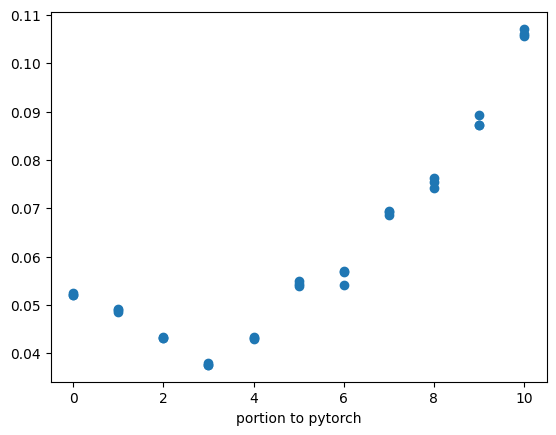

In [22]:
plt.scatter(data.pytorch_portion, data.clock_time / data.clip_count)
plt.xlabel("portion to pytorch")

In [19]:
grouped_portion

,clip_count,clock_time
pytorch_portion,,
0,3132,54.450550
1,3099,50.428875
2,3087,44.393265
3,3039,38.221310
4,3054,43.892155
5,3054,55.309418
6,3069,57.261337
7,3060,70.423737
8,3054,76.624107


Looks like about a 30% speedup from dali

100 clips
pytorch - 1 s per clip
dali - 0.6 s per clip
30 clips for pytorch = 30s
70 clips for dali = 42s
Running just dali = 60s
With full concurrency = 42s

Because we are running Dali on 70% of the input and the time is 70% of the time running with just Dali, we are getting full concurrency when running without the model!

For ideal fraction: minimize 0.6d + p; where d + p = 1

#### More fine grained data

In [6]:
con.execute("SELECT * FROM combo_full_benchmark WHERE eid=1674685100592")
data = con.df()

Text(0, 0.5, 'clock time per clip')

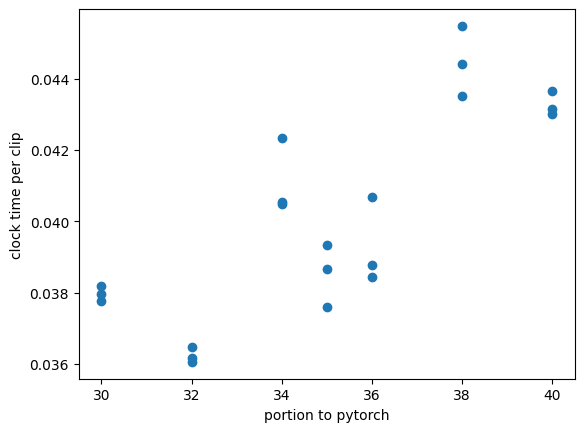

In [7]:
plt.scatter(data.pytorch_portion, data.clock_time / data.clip_count)
plt.xlabel("portion to pytorch")
plt.ylabel("clock time per clip")

#### Queue size - is model the bottleneck?

In [13]:
con.execute("SELECT * FROM combo_full_benchmark WHERE eid=1674885466536")
full_benchmark = con.df()

In [20]:
full_benchmark

,eid,iteration,pytorch_portion,dali_portion,clip_count,clock_time,max_q_size
0,1674885466536,0,35,65,1015,68.767029,1
1,1674885466536,0,35,65,1015,66.907616,5
2,1674885466536,0,35,65,1015,67.238838,10
3,1674885466536,0,35,65,1015,67.221405,50


In [14]:
con.execute("SELECT * FROM queue_block WHERE eid=1674885466536")
data = con.df()

In [15]:
data.groupby("pid").agg({"start_time": "max", "size_before": "max"}).sort_values("start_time")

,start_time,size_before
pid,,
3048717,2023-01-28 05:58:43.280575,1
3048718,2023-01-28 05:58:56.560424,1
3050007,2023-01-28 05:59:52.358028,5
3050008,2023-01-28 06:00:03.932110,5
3051293,2023-01-28 06:00:58.999752,10
3051294,2023-01-28 06:01:09.492469,10
3052574,2023-01-28 06:01:54.986612,47
3052575,2023-01-28 06:02:01.166552,47
3048559,2023-01-28 06:02:21.853977,48


In [16]:
con.close()

In [17]:
pid_to_qsize = {3048717: 1, 3048718: 1, 3050007: 5, 3050008: 5, 3051293: 10, 3051294: 10, 3052574: 50, 3052575: 50, 3048559: 50}
pid_to_qsize = {3048717: "1", 3048718: "1", 3050007: "5", 3050008: "5", 3051293: "10", 3051294: "10", 3052574: "50", 3052575: "50", 3048559: "50"}

In [18]:
data["max_qsize"] = data.pid.map(lambda x: pid_to_qsize[x])

In [23]:
alt.Chart(data[data.max_qsize == "10"]).mark_point().encode(x='start_time', y='size_before', color='max_qsize', tooltip=['start_time', 'size_before', 'max_qsize']).interactive()

alt.Chart(...)

In [24]:
data

,eid,operation,pid,dataloader,start_time,size_before,size_after,duration
0,1674885466536,put,3048718,DALI,2023-01-28 05:57:52.871965,0,1,0.000288
1,1674885466536,put,3048718,DALI,2023-01-28 05:57:52.878357,0,1,0.000026
2,1674885466536,get,3048559,NONE,2023-01-28 05:57:48.584644,0,1,4.296496
3,1674885466536,put,3048718,DALI,2023-01-28 05:57:52.880608,1,1,1.497335
4,1674885466536,get,3048559,NONE,2023-01-28 05:57:54.377806,1,1,0.001284
...,...,...,...,...,...,...,...,...
1035,1674885466536,get,3048559,NONE,2023-01-28 06:02:19.945485,5,4,0.000404
1036,1674885466536,get,3048559,NONE,2023-01-28 06:02:20.422531,4,3,0.000337
1037,1674885466536,get,3048559,NONE,2023-01-28 06:02:20.899462,3,2,0.000354
1038,1674885466536,get,3048559,NONE,2023-01-28 06:02:21.377818,2,1,0.000348


In [5]:
con.execute("SELECT * FROM combo_full_benchmark WHERE eid=1675822820356")
data = con.df()

In [7]:
alt.Chart(data).mark_point().encode(x='pytorch_portion', y='mean(clock_time)', tooltip=['mean(clock_time)']).interactive()

alt.Chart(...)

,eid,iteration,pytorch_portion,dali_portion,clip_count,clock_time,max_q_size
0,1675822820356,0,0,100,1562,79.407883,50
1,1675822820356,0,10,90,1556,73.199699,50
2,1675822820356,0,20,80,1553,66.053192,50
3,1675822820356,0,30,70,1560,60.324421,50
4,1675822820356,0,40,60,1554,63.896042,50
5,1675822820356,0,50,50,1550,74.892654,50
6,1675822820356,0,60,40,1544,89.489281,50
7,1675822820356,0,70,30,1541,105.239334,50
8,1675822820356,0,80,20,1548,122.955139,50
9,1675822820356,0,90,10,1542,126.008812,50
